In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import glob
import sys

sys.path.append("../")
from simulate import gen_bursts, run_search, analyse_and_plot
from utils import *
from plotting import set_size

%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

Simulate bursts 

In [2]:
# FRB121102 with some nominal parameters
np.random.seed(1996)

bursts, name = gen_bursts(
    mu_params=[1650, 250],  # sigma_params=[450, 200],
    sigma_params=[300, 250],
    mu_dist="norm",
    sigma_dist="norm",
    N=50000,
    alpha=-1.5,
    E_min_log=37,
    E_max_log=42,
    save=False,
)

<IPython.core.display.Javascript object>

In [3]:
# Plot cumulative energy distribution and fit a single or double power law to it
def fit_and_plot(
    E,
    ax,
    plot_orig=True,
    plot_fit=True,
    single_law=True,
    double_law=False,
    color="k",
    label="label",
    marker=".",
    s=10,
):
    const = 10 ** 34
    Es = np.sort(E) / const
    Ns = np.linspace(len(Es) - 1, 0, len(Es))

    if plot_orig:
        ax.scatter(np.sort(E), (Ns), c=color, marker=marker, alpha=0.75, s=s)

    if plot_fit:
        ret = {}
        if single_law:
            scale, slope = fit_single_power_law(Ns, Es)
            x = np.sort(E)
            y = single_power_law(Es, scale, slope).astype("float")
            ax.plot(x, y, c=color, label=f"{label}={slope:.3f}")

            ret["single"] = {"scale": scale, "slope": slope}

        if double_law:
            vals = fit_double_power_law(Ns, Es)
            scale, slope1, slope2, break_e = vals
            x = np.sort(E)
            y = double_power_law(Es, scale, break_e, slope1, slope2).astype("float")

            ax.axvline(x=break_e * const, linestyle="--", c=color)

            ax.plot(
                x,
                y,
                linestyle="dotted",
                c=color,
                label=f"{label}={slope2:.3f}",
            )

            ax.set_xscale("log")
            ret["double"] = {
                "scale": scale,
                "slope1": slope1,
                "slope2": slope2,
                "break_e": break_e * const,
            }
        ax.set_yscale("log")
        return ret
    else:
        return 0

<IPython.core.display.Javascript object>

In [4]:
# Plot energy histograms and print statistics of parameters
def analyse_and_plot(bursts, detected, Es, ax, th):

    qs = np.quantile(bursts["in_mu_f"], [0.16, 0.5, 0.84])
    print(f"Injected mu_f is: {qs[1]:.3f}+{(qs[2] - qs[1]):.2f}-{(qs[1] - qs[0]):.2f}")

    qs = np.quantile(detected["in_mu_f"], [0.16, 0.5, 0.84])
    print(f"Recovered mu_f is: {qs[1]:.3f}+{(qs[2] - qs[1]):.2f}-{(qs[1] - qs[0]):.2f}")

    qs = np.quantile(bursts["in_sig_f"], [0.16, 0.5, 0.84])
    print(f"Injected sig_f is: {qs[1]:.2f}+{(qs[2] - qs[1]):.2f}-{(qs[1] - qs[0]):.2f}")

    qs = np.quantile(detected["in_sig_f"], [0.16, 0.5, 0.84])
    print(
        f"Recovered sig_f is: {qs[1]:.2f}+{(qs[2] - qs[1]):.2f}-{(qs[1] - qs[0]):.2f}"
    )

    original_E = Es["original_E"]
    detected_snr_E = Es["detected_snr_E"]
    detected_fit_E = Es["detected_fit_E"]
    detected_in_band_E = Es["detected_in_band_E"]

    ax.hist(np.log10(original_E), bins=50, density=False, alpha=0.5)
    ax.hist(
        np.log10(detected_snr_E),
        bins=50,
        density=False,
        alpha=0.5,
        label=r"F$_{\mathrm{th}}$=~" + str(th) + r"~Jy\,ms",
    )
    ax.set_yscale("log")

<IPython.core.display.Javascript object>

In [5]:
thresholds = [0.02, 0.02 * 10 * 2]

<IPython.core.display.Javascript object>

Run search with thresholds and plot!

0.02
44221 11947
Injected mu_f is: 1647.622+248.70-244.84
Recovered mu_f is: 1577.379+185.38-211.22
Injected sig_f is: 335.28+233.28-198.58
Recovered sig_f is: 143.71+134.48-89.20
0.4
44221 818


/home/kshitij/anaconda3/envs/grbfrb/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/kshitij/anaconda3/envs/grbfrb/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator


Injected mu_f is: 1647.622+248.70-244.84
Recovered mu_f is: 1531.710+175.27-202.40
Injected sig_f is: 335.28+233.28-198.58
Recovered sig_f is: 17.04+68.21-12.19


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


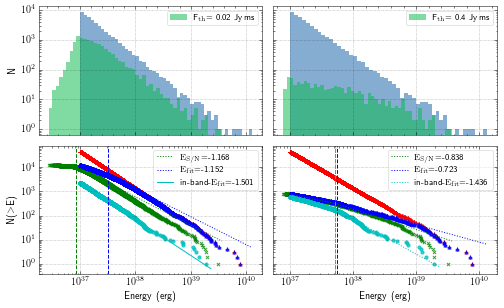

<IPython.core.display.Javascript object>

In [6]:
with plt.style.context(["science", "grid"]):  # , "no-latex"]):
    fig, axes = plt.subplots(
        2,
        2,
        figsize=set_size(width="full", subplots=(2, 2), fraction=1),
        sharey="row",
        sharex=False,
    )
    for i, th in enumerate(thresholds):
        ax = axes[:, i]

        print(th)
        detected, detected_in_band_df, Es = run_search(
            bursts,
            fstart=974,
            fend=1774,
            fluence_threshold=th,
            in_band_sig=3,
            ret="all",
            distance=972,
        )
        print(len(bursts), len(detected))
        #     analyse_and_plot(bursts, detected, Es)
        original_E = Es["original_E"]
        detected_snr_E = Es["detected_snr_E"]
        detected_fit_E = Es["detected_fit_E"]
        detected_in_band_E = Es["detected_in_band_E"]

        fit_vals = {}
        fit_vals["orig"] = fit_and_plot(
            original_E,
            ax[1],
            plot_fit=False,
            plot_orig=True,
            single_law=False,
            double_law=False,
            color="r",
            marker="+",
            s=10,
        )

        fit_vals["detected-snr"] = fit_and_plot(
            detected_snr_E,
            ax[1],
            plot_fit=True,
            plot_orig=True,
            single_law=False,
            double_law=True,
            color="g",
            label=r"$\mathrm{E}_\mathrm{S/N}$",
            marker="x",
        )

        if i == 0:
            double_law = False
        else:
            double_law = True

        fit_vals["detected-fit"] = fit_and_plot(
            detected_fit_E,
            ax[1],
            plot_fit=True,
            plot_orig=True,
            single_law=False,
            double_law=True,
            color="b",
            label=r"$\mathrm{E}_\mathrm{fit}$",
            marker="^",
        )

        if i == 1 or i == 2:
            single_law = False
        else:
            single_law = True

        fit_vals["detected-in-band"] = fit_and_plot(
            detected_in_band_E,
            ax[1],
            plot_fit=True,
            plot_orig=True,
            single_law=single_law,
            double_law=double_law,
            color="c",
            label=r"in-band-$\mathrm{E}_\mathrm{fit}$",
            marker="o",
        )
        legend = ax[1].legend(fontsize="small")  # loc="lower left")
        legend.get_frame().set_alpha(0.5)

        analyse_and_plot(bursts, detected, Es, ax[0], th)

        if i == 0:
            ax[1].set_ylabel(r"N($>$E)")
            ax[0].set_ylabel(r"N")

        #     labels = [str(10 ** item._x) for item in ax[1].get_xticklabels()]
        labels = [item._text for item in ax[1].get_xticklabels()]
        ax[0].set_xticklabels(labels)
        ax[0].legend()  # set_title(f"Fluence={th}Jyms")

        legend = ax[0].legend(fontsize="small")  # loc="lower left")
        legend.get_frame().set_alpha(0.5)

        ax[1].set_xlabel("Energy (erg)")

    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    plt.tight_layout()
    plt.savefig("energy_pdf_cdf.png", bbox_inches="tight", dpi=300)